# Tic Tac Toe Challenge

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

The easiest way to allow you to program your own Tic Tac Toe player is to program different algorithms using classes. Classes allow attributes and functions to be shared across different version of the class.

So, we can define a general <code>TicTacToePlayer</code> as a class that knows how to be assigned a game to play and a player number, and knows how to figure out which moves are available to play. What differs across different types of players is how the move is determined. We create a <code>getMove</code> function that different player types will implement differently:

In [2]:
class TicTacToePlayer:
    playerNumber = -1
    game = None
    
    def getName(self):
        raise('This method must be implemented. Name your algorithm!')
    
    def getMove(self):
        raise('This method must be implemented.')
    
    def getAvailableMoves(self, state=None):
        if state is None: state = self.game.state
            
        moves = np.where(state==0)
        moves = [(x,y) for (x,y) in zip(moves[0], moves[1])]
        return moves
    
    def setGameAndPlayerNumber(self, ticTacToeGame, playerNumber):
        self.game = ticTacToeGame
        self.playerNumber = playerNumber
        
    # this is called by the tic tac toe game (self.game) when play has
    # finished. this is a good time to do some learning. outcome is one
    # of {1-X won; 2-O won; 0-draw}
    def gameComplete(self, outcome):
        pass

To create a specific type of player, we create a new player based on the general <code>TicTacToePlayer</code> and implement the <code>getMove</code> function. Different versions of <code>TicTacToePlayer</code> inheret all of the abilities of the general <code>TicTacToePlayer</code> and can add on new abilities.

The simplest type of new player to add is a <code>RandomPlayer</code>. This player determines its next move by getting a list of all moves available and selecting among them randomly:

In [3]:
class RandomPlayer(TicTacToePlayer):
    def getName(self):
        return 'Random'
    
    def getMove(self):
        moves = self.getAvailableMoves()
        return moves[ np.random.choice(len(moves)) ]

Slightly more complicated is the <code>AggroPlayer</code>. This player tests to see if it can win on the next move. If so, it takes that move. Otherwise, it responds randomly:

In [4]:
class AggroPlayer(TicTacToePlayer):
    def getName(self):
        return 'Aggro'
    
    def getMove(self):
        moves = self.getAvailableMoves()
        
        for m in moves:
            testState = self.game.state.copy()
            testState[m[0], m[1]] = self.playerNumber
            if self.game.isGameWinner(state=testState):
                return m
        
        return moves[ np.random.choice(len(moves)) ]

Of course, you can build in more complicated strategies, such as this <code>CornerPlayer</code>:

In [5]:
class CornerPlayer(TicTacToePlayer):
    def getName(self):
        return 'Corner'
    
    def getMove(self):
        moves = self.getAvailableMoves()
        
        # first priority, see if a win is available
        for m in moves:
            testState = self.game.state.copy()
            testState[m[0], m[1]] = self.playerNumber
            if self.game.isGameWinner(state=testState):
                return m
            
        # second priority, defend against loss
        for m in moves:
            testState = self.game.state.copy()
            testState[m[0], m[1]] = 2 if self.playerNumber==1 else 1
            if self.game.isGameWinner(state=testState):
                return m
            
        # third priority, center position
        if (1,1) in moves: return (1,1)
        
        # fourth priority, corners
        for m in moves:
            if m in [(0,0), (0,2), (2,0), (2,2)]:
                return m
        
        # fifth priority, none -- random
        return moves[ np.random.choice(len(moves)) ]

Critical for our tournament, we need a human player. This asks for a number between 0 and 8 via keyboard input and moves based on the input – as long as the move is allowed.

In [6]:
class HumanPlayer(TicTacToePlayer):
    def getName(self):
        return 'HomoTicTacToeicus'
    
    def getMove(self):
        moves = self.getAvailableMoves()
        m = (-1,-1)
        while not m in moves:
            m = int(input('Player ' + str(self.playerNumber) + ' select position to move: '))
            m = ( int(m/3), m%3 )
        return m

Finally, we implement the Tic Tac Toe Game itself. This contains the rules of the game in <code>isGameWinner</code>, knows how to draw the game with <code>drawBoard</code>, and can run a game with <code>startGame</code>.

In [7]:
class TicTacToeGame:
    # the game state. a value of zeros at [i][j] means that the i,jth position is
    # empty. a value of 1 is an X and a value of 2 is an O
    state = np.zeros((3,3))
    
    # list of the two TicTacToePlayers who take turns moving
    players = []
    # start with playerToMove=0, corresponding to player 1
    # when playerToMove==2, it is player 2's turn
    playerToMove = 0
    
    # the object onto which the game board is drawn
    figure, axis = None, None
    
    # flag to indicate whether the game board should be drawn. if you are training
    # your algorithm for many iterations, you probably want to set this to False.
    # setting shouldDrawBoard is accomplished during the creation of the TicTacToeGame.
    # specifically, calling TicTacToeGame(Player1(), Player2(), shouldDrawBoard=False)
    # will cause the board not to be drawn.
    shouldDrawBoard = True
    
    # draw the game board
    def drawBoard(self, state=None):
        if state is None: state=self.state
            
        self.axis.plot([0,3], [1,1], 'k-')
        self.axis.plot([0,3], [2,2], 'k-')
        self.axis.plot([1,1], [0,3], 'k-')
        self.axis.plot([2,2], [0,3], 'k-')
        
        for i in range(3):
            for j in range(3):
                if state[i,j] == 1:
                    self.axis.plot([j+.1,j+.9], [i+.9,i+.1], 'b-', linewidth=2)
                    self.axis.plot([j+.1,j+.9], [i+.1,i+.9], 'b-', linewidth=2)
                elif state[i,j] == 2:
                    circle = plt.Circle((j+.5,i+.5), radius=0.4, fc='w', ec='r', lw=2)
                    self.axis.add_patch(circle)
                else:
                    self.axis.text(i+.05, j+.15, str(3*j+i), color='#ababab')
        self.figure.canvas.draw()
        
    # determines if there are three Xs or Os in a row. if three Xs, returns 1.
    # if three Os, returns 2. if neither, returns 0.
    def isGameWinner(self, state=None):
        if state is None: state=self.state
        
        # check each row and column
        for i in range(3):
            if np.prod(state[i,:])==1 or np.prod(state[i,:])==8:
                return state[i,0]
            if np.prod(state[:,i])==1 or np.prod(state[:,i])==8:
                return state[0,i]
        # check diagonals
        diag1 = np.prod([ state[0,0], state[1,1], state[2,2] ])
        diag2 = np.prod([ state[0,2], state[1,1], state[2,0] ])
        if diag1==1 or diag2==1 or diag1==8 or diag2==8:
            return state[1,1]
        
        return 0
    
    # starts and runs a game until a winner is determined or all board spaces are
    # filled
    def startGame(self):
        # initialize the game state to an empty board (all zeros)
        self.state = np.zeros((3,3))
        # set the first player to move to be player 1 (index 0 in the players list)
        self.playerToMove = 0
        
        # create the plot that will be used to display the game board
        if self.shouldDrawBoard:
            plt.rcParams['figure.figsize'] = (5,5)
            self.figure, self.axis = plt.subplots()
            plt.gca().invert_yaxis()
            plt.axis('off')
        
        # game continues until winner or all positions filled (filled -> non-zero)
        while not self.isGameWinner(self.state) and len(np.argwhere(self.state==0)):
            # draw the game board
            if self.shouldDrawBoard: self.drawBoard(self.state)
            
            # for code brevity, create thisPlayer to be the next player to move
            # note that playerToMove is 0 for player 1/X and is 1 for player 2/O
            thisPlayer = self.players[self.playerToMove]
            
            # request the move to play
            move = thisPlayer.getMove()
            
            # place an X or O at the requested matrix position
            self.state[ move[0], move[1] ] = self.playerToMove+1
            
            # switch playerToMove: 0->1 or 1->0
            self.playerToMove = (self.playerToMove+1) % 2
        
        # send players the signal that the game is finished
        for p in self.players: p.gameComplete(self.isGameWinner(self.state))
        # draw the final board state
        if self.shouldDrawBoard: self.drawBoard(self.state)
        
        # print the outcome
        if self.isGameWinner():
            winNum = int(self.isGameWinner(self.state))
            winXO = 'X' if winNum == 1 else 'O'
            winName = self.players[winNum-1].getName()
            
            winner = winName + ' (' + winXO + ')'
            print(winner + ' wins!')
        else:
            print('Draw')
        
    
    # called when TicTacToeGame is created
    def __init__(self, player1, player2, shouldDrawBoard=True):
        player1.setGameAndPlayerNumber(self, 1)
        player2.setGameAndPlayerNumber(self, 2)
        self.players = [player1, player2];
        self.shouldDrawBoard = shouldDrawBoard
        self.startGame()

The big advantage of programming players and the game using classes is that it allows for great flexibility in running games. Specifically, a game can be created by creating different player instances and assigning each player to X and O. For example to have <code>RandomPlayer</code> play <code>AggroPlayer</code>, you run:

<IPython.core.display.Javascript object>


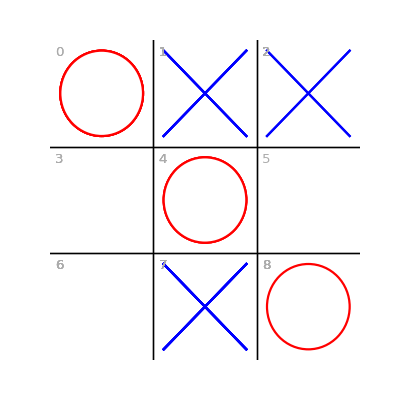

Aggro (O) wins!


In [8]:
TicTacToeGame(RandomPlayer(), AggroPlayer());

You can check whether <code>CornerPlayer</code> can beat <code>RandomPlayer</code> three times in a row by running:

In [63]:
for i in range(10):
    TicTacToeGame(RandomPlayer(), AggroPlayer(), shouldDrawBoard=False)

Aggro (O) wins!
Random (X) wins!
Random (X) wins!
Random (X) wins!
Aggro (O) wins!
Aggro (O) wins!
Aggro (O) wins!
Random (X) wins!
Random (X) wins!
Aggro (O) wins!


And you can try to beat <code>CornerPlayer</code> yourself by running:

<IPython.core.display.Javascript object>


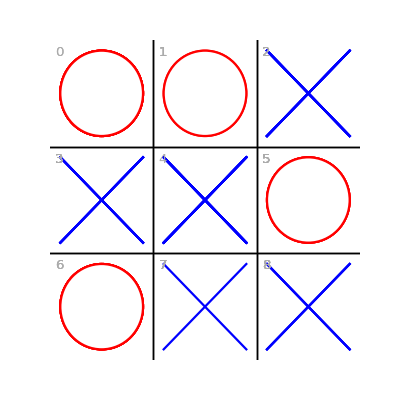

Player 2 select position to move: 0
Player 2 select position to move: 6
Player 2 select position to move: 5
Player 2 select position to move: 1
Draw


In [64]:
TicTacToeGame(CornerPlayer(), HumanPlayer())

Your task is to program your own <code>TicTacToePlayer</code> that learns to play on its own using one of the reinforcement learning (RL) models that we have studied. 

All RL models work by assigning values to some combination of states and/or actions. In reality, there are relatively few possible states in Tic Tac Toe. However, determining the list of possible game states is complicated. For simplicity of programming, we can assume that each of the 9 spots on the board may be (1) empty, (2) occupied by an X, or (3) occupied by an O. This means that there are $3^9$ possible states and 9 possible actions for each state. We can then create a general reinforcement learning player that knows how to assign numbers to all possible board states and moves:

In [9]:
class RLPlayer(TicTacToePlayer):
    def getTotalNumberOfStates(self):
        return 3**9
    
    def getTotalNumberOfActions(self):
        return 9
    
    # converts game state to a number between 0 and 3^9 (minus 1)
    # if the game state is not specified, current game board state
    # is used.
    def getStateAsNumber(self, state=None):
        if state is None: state = self.game.state
        
        stateNum = 0
        for row in range(3):
            for col in range(3):
                pos = 3 * row + col
                stateNum += state[row][col] * 3**pos
        
        return int(stateNum)
    
    # converts move to a number between 0 and 8
    def getMoveAsNumber(self, move):
        (row, col) = move
        return int(3*row + col)

We have programmed RL algorithms that choose based on the value of potential next states $V(s)$, based on state-action values $Q(s,a)$, and based on tree search using learned transition matrices $T(s,a,s')$. Below are some outlines of what Tic Tac Toe players built off of these algorithms may look like:

<IPython.core.display.Javascript object>


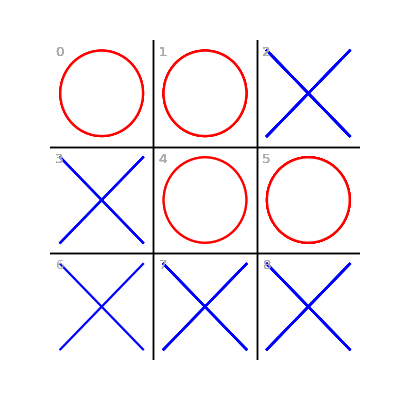

Random (X) wins!


In [10]:
class VLearningPlayer(RLPlayer):
    # state values
    V = None
    
    def getName(self):
        return 'VLearningPlayer'
    
    def getMove(self):
        state = self.game.state
        
        # figure out what moves are available
        moves = self.getAvailableMoves(state)
        
        # determine the value, V, of each possible next state
        Vnext = []
        
        for m in moves:
            testState = self.game.state.copy()
            testState[m[0], m[1]] = self.playerNumber
            testStateNumber = self.getStateAsNumber(testState)
            Vnext.append( self.V[testStateNumber] )
            
        # choose move to play based on Vnext
        # for now, just choose randomly
        moveToPlay = moves[ np.random.choice(len(moves)) ]
        
        # maybe update the V from the last move based on Vnext
        
        # maybe remember the Vnext selected so that you can update it
        # on the next trial
        
        # don't forget to return to the game the move you want to play
        return moveToPlay
        
    def gameComplete(self, outcome):
        # determine whether you won / lost / drew. assign a reward
        # value based on these outcomes
        if (outcome == self.playerNumber):
            # a win!
            r = 1
        elif (outcome == 0):
            # draw
            r = 0
            # or...
            r = 0.5
        else:
            # loss
            r = -1
        
        # maybe update your V values based on r
        
        # maybe save the updated V matrix to a file
        #if self.playerNumber == 1:
        #    np.save('Values1.npy', self.V)
        #else:
        #    np.save('Values2.npy', self.V)
    
    def setGameAndPlayerNumber(self, ticTacToeGame, playerNumber):
        self.game = ticTacToeGame
        self.playerNumber = playerNumber
        
        # good idea to load the right V matrix at once the player number is set
        #if self.playerNumber == 1:
        #    self.V = np.load('Values1.npy')
        #else:
        #    self.V = np.load('Values2.npy')
    
    def __init__(self):
        super().__init__()
    
        # initialize weights to be all zeros
        self.V = np.zeros(self.getTotalNumberOfStates())
        
        # or perhaps random numbers
        self.V = np.random.uniform(size=self.getTotalNumberOfStates())
        
        
TicTacToeGame(RandomPlayer(), VLearningPlayer())

<IPython.core.display.Javascript object>


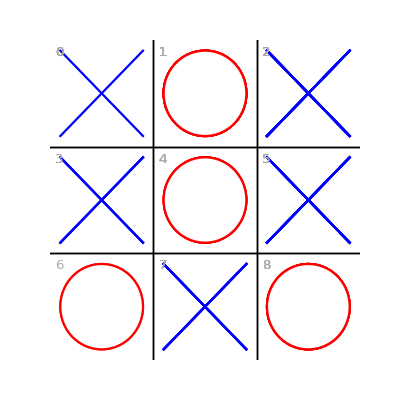

Draw


In [19]:
class QLearningPlayer(RLPlayer):
    Q = None
    
    def getName(self):
        return 'QLearningPlayer'
    
    def getMove(self):
        # figure out what moves are available
        state = self.game.state
        moves = self.getAvailableMoves(state)
        
        # determine the values, Q, of each possible action from the
        # the current state
        Qnext = []
        s = self.getStateAsNumber(self.game.state)
        
        for m in moves:
            a = self.getMoveAsNumber(m)
            Qnext.append( self.Q[s,a] )
            
        # choose move to play based on Qnext
        # for now, just choose randomly
        moveToPlay = moves[ np.random.choice(len(moves)) ]
        
        # maybe update the Q(s,a) from the last move based on Qnext
        # perhaps using the SARSA update method, perhaps using the Q-learning
        # method
        
        # maybe remember the Q(s,a) selected so that you can update it
        # on the next trial
        
        # don't forget to return the move you want to play
        return moveToPlay
        
    def gameComplete(self, outcome):
        # determine whether you won / lost / drew. assign a reward
        # value based on these outcomes
        if (outcome == self.playerNumber):
            # a win!
            r = 1
        elif (outcome == 0):
            # draw
            r = 0
            # or...
            r = 0.5
        else:
            # loss
            r = -1
            
        # maybe update your Q values based on r
        
        # maybe save the updated Q matrix to a file
        #if self.playerNumber == 1:
        #    np.save('QValues1.npy', self.Q)
        #else:
        #    np.save('QValues2.npy', self.Q)

    def setGameAndPlayerNumber(self, ticTacToeGame, playerNumber):
        self.game = ticTacToeGame
        self.playerNumber = playerNumber
        
        # good idea to load the right Q matrix at once the player number is set
        #if self.playerNumber == 1:
        #    self.Q = np.load('QValues1.npy')
        #else:
        #    self.Q = np.load('QValues2.npy')
    
    def __init__(self):
        super().__init__()
    
        # initialize weights to be all zeros
        self.Q = np.zeros( (self.getTotalNumberOfStates(),self.getTotalNumberOfActions()) )
        
        # or perhaps random numbers
        self.Q = np.random.uniform( size=(self.getTotalNumberOfStates(),self.getTotalNumberOfActions()) )
        
TicTacToeGame(RandomPlayer(), QLearningPlayer())

<IPython.core.display.Javascript object>


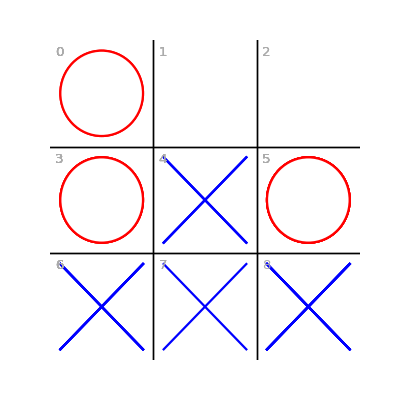

ModelBasedPlayer (X) wins!


In [35]:
class ModelBasedPlayer(RLPlayer):
    T = None
    
    def getName(self):
        return 'ModelBasedPlayer'
    
    def getMove(self):
        # figure out what moves are available
        state = self.game.state
        moves = self.getAvailableMoves(state)
        
        # determine the values, Q, of each possible action from the
        # the current state
        Qnext = []
        s = self.getStateAsNumber(self.game.state)
        
        for m in moves:
            a = self.getMoveAsNumber(m)
            # you will need to create a forward search algorithm that
            # uses T to estimate likely future outcomes for different
            # actions
            
        # choose move to play based on Qnext
        # for now, just choose randomly
        moveToPlay = moves[ np.random.choice(len(moves)) ]
        
        # maybe update the T based on the state you just reached, the
        # last state in which you made a move, and the action that you
        # took. don't forget to decrease the T values for the states
        # not reached.
        
        # don't forget to return the move you want to play
        return moveToPlay
        
    def gameComplete(self, outcome):
        # don't worry about updating something like the estimated reward
        # for each terminal state. the T matrix is the real object of 
        # learning here (trying to predict what the other player will do).
        
        # however, it is a good idea to update your T matrix one last time
        # when the terminal state is reached
        
        # maybe save the updated T matrix to a file
        #if self.playerNumber == 1:
        #    np.save('Transition1.npy', self.T)
        #else:
        #    np.save('Transition2.npy', self.T)
        pass

    def setGameAndPlayerNumber(self, ticTacToeGame, playerNumber):
        self.game = ticTacToeGame
        self.playerNumber = playerNumber
        
        # good idea to load the right T matrix at once the player number is set
        #if self.playerNumber == 1:
        #    self.T = np.load('Transition1.npy')
        #else:
        #    self.T = np.load('Transition2.npy')
    
    def __init__(self):
        super().__init__()
        
        Tsize = (self.getTotalNumberOfStates(),self.getTotalNumberOfActions(), self.getTotalNumberOfStates())
    
        # initialize transition probabilities to be all zeros since actual
        # transition matrix will be mostly zeros
        self.T = np.zeros(Tsize)
        
TicTacToeGame(ModelBasedPlayer(), RandomPlayer())